In [ ]:
## I create venv then run this
%pip install pandas numpy sentence-transformers
%pip install scikit-learn
%pip install torch
%pip install matplotlib

In [9]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import json
import re
from sklearn.model_selection import train_test_split
import torch

In [2]:
def load_dataset(filepath: str):
    """Loads a JSON lines file into a list of dictionaries."""
    dataset = []
    with open(filepath, "r") as f:
        for line in f:
            if line.strip():
                dataset.append(json.loads(line))
    return dataset

# Load the datasets
reviews_df = pd.DataFrame(load_dataset("dataset/IMDB_reviews.json"))
details_df = pd.DataFrame(load_dataset("dataset/IMDB_movie_details.json"))

# Clean reviews data
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], errors='coerce')
reviews_df['is_spoiler'] = reviews_df['is_spoiler'].astype(bool)
reviews_df['rating'] = pd.to_numeric(reviews_df['rating'], errors='coerce')

# Clean movie details data
def duration_to_minutes(duration):
    if not isinstance(duration, str):
        return np.nan
    hour_match = re.search(r'(\d+)\s*h', duration)
    min_match = re.search(r'(\d+)\s*min', duration)
    hours = int(hour_match.group(1)) if hour_match else 0
    minutes = int(min_match.group(1)) if min_match else 0
    return (hours * 60) + minutes

details_df['duration'] = details_df['duration'].apply(duration_to_minutes)
details_df['release_date'] = pd.to_datetime(details_df['release_date'], errors='coerce')
details_df['plot_synopsis'].replace("", np.nan, inplace=True)
details_df['plot_summary'].replace("", np.nan, inplace=True)

# Merge the two dataframes
df = pd.merge(reviews_df, details_df, on='movie_id', how='left')

print("Data loaded and merged successfully.")
df[['movie_id', 'review_text', 'plot_summary', 'plot_synopsis', 'is_spoiler']].head()

/var/folders/qh/mf0p507j6zs86wwkmbnl0lq40000gn/T/ipykernel_2386/2777841105.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  details_df['plot_synopsis'].replace("", np.nan, inplace=True)
/var/folders/qh/mf0p507j6zs86wwkmbnl0lq40000gn/T/ipykernel_2386/2777841105.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Data loaded and merged successfully.


,movie_id,review_text,plot_summary,plot_synopsis,is_spoiler
0,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",Chronicles the experiences of a formerly succe...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True
1,tt0111161,The Shawshank Redemption is without a doubt on...,Chronicles the experiences of a formerly succe...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True
2,tt0111161,I believe that this film is the best story eve...,Chronicles the experiences of a formerly succe...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True
3,tt0111161,"**Yes, there are SPOILERS here**This film has ...",Chronicles the experiences of a formerly succe...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True
4,tt0111161,At the heart of this extraordinary movie is a ...,Chronicles the experiences of a formerly succe...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",True


MPS device found. Using GPU.
Calculating Review vs Synopsis similarities for 538828 pairs...


Batches: 100%|██████████| 16839/16839 [32:12<00:00,  8.71it/s] 


Calculating Review vs Summary similarities for 573906 pairs...


Batches: 100%|██████████| 17935/17935 [17:38<00:00, 16.94it/s] 


Calculating Synopsis vs Summary similarities for 538828 pairs...


Batches: 100%|██████████| 16839/16839 [17:00<00:00, 16.50it/s]



Similarity scores calculated and added to the dataframe.


,is_spoiler,sim_synopsis_review,sim_summary_review,sim_synopsis_summary
0,True,0.535355,0.512277,0.690404
1,True,0.750936,0.720940,0.690404
2,True,0.760892,0.737936,0.690404
3,True,0.224949,0.280551,0.690404
4,True,0.697725,0.643839,0.690404


In [10]:
# --- Step 1: Train-Test Split ---
# We split the main DataFrame first to prevent any data leakage.
# We use the 80/20 split and stratification from your original notebook.
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['is_spoiler'],
    random_state=42
)
print(f"Data split into train ({len(train_df)}) and test ({len(test_df)}) sets.")

# --- Step 2: Setup Model and Device ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")
    
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- Step 3: Embedding Generation ---
# We fill NaNs with empty strings. The model will encode these as valid vectors,
# which allows us to keep the indices aligned.

# --- Encode Training Set ---
print("\nEncoding training set texts...")
train_review_embeddings = model.encode(train_df['review_text'].fillna('').tolist(), 
                                       convert_to_tensor=True, show_progress_bar=True, device=device)
train_synopsis_embeddings = model.encode(train_df['plot_synopsis'].fillna('').tolist(), 
                                         convert_to_tensor=True, show_progress_bar=True, device=device)
train_summary_embeddings = model.encode(train_df['plot_summary'].fillna('').tolist(), 
                                        convert_to_tensor=True, show_progress_bar=True, device=device)
print("Training set encoded.")

# --- Encode Test Set ---
print("\nEncoding test set texts...")
test_review_embeddings = model.encode(test_df['review_text'].fillna('').tolist(), 
                                      convert_to_tensor=True, show_progress_bar=True, device=device)
test_synopsis_embeddings = model.encode(test_df['plot_synopsis'].fillna('').tolist(), 
                                        convert_to_tensor=True, show_progress_bar=True, device=device)
test_summary_embeddings = model.encode(test_df['plot_summary'].fillna('').tolist(), 
                                       convert_to_tensor=True, show_progress_bar=True, device=device)
print("Test set encoded.")

# --- Move embeddings to CPU for easier processing ---
train_review_cpu = train_review_embeddings.cpu()
train_synopsis_cpu = train_synopsis_embeddings.cpu()
train_summary_cpu = train_summary_embeddings.cpu()

test_review_cpu = test_review_embeddings.cpu()
test_synopsis_cpu = test_synopsis_embeddings.cpu()
test_summary_cpu = test_summary_embeddings.cpu()

print("\n--- All embeddings generated and ready for similarity calculation. ---")

Data split into train (459130) and test (114783) sets.
MPS device found. Using GPU.

Encoding training set texts...


Batches: 100%|██████████| 14348/14348 [14:55<00:00, 16.03it/s]


Training set encoded.

Encoding test set texts...


Batches: 100%|██████████| 3587/3587 [03:46<00:00, 15.85it/s]


Test set encoded.

--- All embeddings generated and ready for similarity calculation. ---


In [30]:
# --- Step 4: Calculate Similarities (using pre-computed embeddings) BETWEEN REVIEW AND SYNOPSIS/SUMMARY ---
# We calculate pairwise similarity for all three combinations on both train and test sets.

print("Calculating similarities for training set...")
# Comparison 1: Review vs. Synopsis
sim_scores_1_train_cos_sim = util.pairwise_cos_sim(train_review_cpu, train_synopsis_cpu)
train_df_cos_sim['sim_synopsis_review'] = sim_scores_1_train_cos_sim.flatten()

# Comparison 2: Review vs. Summary
sim_scores_2_train_cos_sim = util.pairwise_cos_sim(train_review_cpu, train_summary_cpu)
train_df_cos_sim['sim_summary_review'] = sim_scores_2_train_cos_sim.flatten()

# Comparison 3: Synopsis vs. Summary
sim_scores_3_train_cos_sim = util.pairwise_cos_sim(train_synopsis_cpu, train_summary_cpu)
train_df_cos_sim['sim_synopsis_summary'] = sim_scores_3_train_cos_sim.flatten()

print("Calculating similarities for test set...")
# Test Set
sim_scores_1_test_cos_sim = util.pairwise_cos_sim(test_review_cpu, test_synopsis_cpu)
test_df_cos_sim['sim_synopsis_review'] = sim_scores_1_test_cos_sim.flatten()

sim_scores_2_test_cos_sim = util.pairwise_cos_sim(test_review_cpu, test_summary_cpu)
test_df_cos_sim['sim_summary_review'] = sim_scores_2_test_cos_sim.flatten()

sim_scores_3_test_cos_sim = util.pairwise_cos_sim(test_synopsis_cpu, test_summary_cpu)
test_df_cos_sim['sim_synopsis_summary'] = sim_scores_3_test_cos_sim.flatten()

# --- Step 5: Clean Up Scores ---
# We set scores to NaN where the original text was missing. 
# This ensures our analysis only compares valid scores.

print("Cleaning up similarity scores based on original missing text...")
# Training Set
train_df_cos_sim['sim_synopsis_review'] = train_df_cos_sim['sim_synopsis_review'].where(train_df_cos_sim['plot_synopsis'].notna())
train_df_cos_sim['sim_summary_review'] = train_df_cos_sim['sim_summary_review'].where(train_df_cos_sim['plot_summary'].notna())
train_df_cos_sim['sim_synopsis_summary'] = train_df_cos_sim['sim_synopsis_summary'].where(train_df_cos_sim['plot_synopsis'].notna() & train_df_cos_sim['plot_summary'].notna())

# Test Set
test_df_cos_sim['sim_synopsis_review'] = test_df_cos_sim['sim_synopsis_review'].where(test_df_cos_sim['plot_synopsis'].notna())
test_df_cos_sim['sim_summary_review'] = test_df_cos_sim['sim_summary_review'].where(test_df_cos_sim['plot_summary'].notna())
test_df_cos_sim['sim_synopsis_summary'] = test_df_cos_sim['sim_synopsis_summary'].where(test_df_cos_sim['plot_synopsis'].notna() & test_df_cos_sim['plot_summary'].notna())


# --- Step 6: Analysis of Results (using TRAINING data only) ---

# Group by 'is_spoiler' on the training set and calculate the mean
cos_sim_analysis_df = train_df_cos_sim.dropna(subset=['sim_synopsis_review', 'sim_summary_review']).groupby('is_spoiler')[
    ['sim_synopsis_review', 'sim_summary_review']
].mean()

# Calculate the difference (gap) between True and False scores
if True in cos_sim_analysis_df.index and False in cos_sim_analysis_df.index:
    cos_sim_analysis_df.loc['difference'] = cos_sim_analysis_df.loc[True] - cos_sim_analysis_df.loc[False]
else:
    print("Warning: Could not calculate difference (one class is missing).")
    cos_sim_analysis_df.loc['difference'] = [np.nan, np.nan]

# Calculate the average similarity between synopsis and summary
avg_syn_sum_sim_cos_sim = train_df_cos_sim['sim_synopsis_summary'].dropna().mean()

print("\n--- Analysis of Review vs. Description Similarity (on Training Data) ---")
print(cos_sim_analysis_df.round(4))
print("\n--- Analysis of Synopsis vs. Summary Similarity (on Training Data) ---")
print(f"Average similarity between synopsis and summary: {avg_syn_sum_sim_cos_sim:.4f}")

# --- Interpretation ---
if not cos_sim_analysis_df.loc['difference'].isnull().any():
    if cos_sim_analysis_df.loc['difference', 'sim_summary_review'] > cos_sim_analysis_df.loc['difference', 'sim_synopsis_review']:
        print(f"\nDecision: 'sim_summary_review' shows a larger separation ({cos_sim_analysis_df.loc['difference', 'sim_summary_review']:.4f}) and is the better predictor.")
    else:
        print(f"\nDecision: 'sim_synopsis_review' shows a larger separation ({cos_sim_analysis_df.loc['difference', 'sim_synopsis_review']:.4f}) and is the better predictor.")

    if avg_syn_sum_sim_cos_sim > 0.75:
        print(f"Fallback Justified: Synopsis and Summary similarity ({avg_syn_sum_sim_cos_sim:.4f}) is high. Using the other as a fallback is recommended.")
    else:
        print(f"Fallback Not Justified: Synopsis and Summary similarity ({avg_syn_sum_sim_cos_sim:.4f}) is relatively low.")
else:
    print("\nCould not determine primary feature due to missing data.")
    
    
    
    
# --- Step 8: Create the Independent DataFrames ---
if primary_sim_feature:
    # Create the new training feature DataFrame
    X_train_cos_sim_features = train_df_cos_sim[['sim_synopsis_review']].copy()
    
    # Create the new test feature DataFrame
    X_test_cos_sim_features = test_df_cos_sim[['sim_synopsis_review']].copy()

    # --- FIX: Handle NaNs by re-assigning the column ---
    # This avoids the FutureWarning.
    X_train_cos_sim_features['sim_synopsis_review'] = X_train_cos_sim_features['sim_synopsis_review'].fillna(0.0)
    X_test_cos_sim_features['sim_synopsis_review'] = X_test_cos_sim_features['sim_synopsis_review'].fillna(0.0)
    
    print("\nIndependent feature set 'X_train_cos_sim_features' created successfully.")
    print(X_train_cos_sim_features.head())
else:
    print("\nERROR: Could not create similarity feature set.")

Calculating similarities for training set...
Calculating similarities for test set...
Cleaning up similarity scores based on original missing text...

--- Analysis of Review vs. Description Similarity (on Training Data) ---
            sim_synopsis_review  sim_summary_review
is_spoiler                                         
False                    0.3616              0.3437
True                     0.4114              0.3919
difference               0.0497              0.0483

--- Analysis of Synopsis vs. Summary Similarity (on Training Data) ---
Average similarity between synopsis and summary: 0.5746

Decision: 'sim_synopsis_review' shows a larger separation (0.0497) and is the better predictor.
Fallback Not Justified: Synopsis and Summary similarity (0.5746) is relatively low.

Independent feature set 'X_train_cos_sim_features' created successfully.
        sim_synopsis_review
94625              0.590531
89585              0.309651
187840             0.378856
265694             0.

y_train (labels) created with 459130 samples.
y_test (labels) created with 114783 samples.
Original training set shape: (459130, 1)
Original spoiler count: 120739

Resampled training set shape: (676782, 1)
Resampled spoiler count: 338391
Training Model 1 (Cosine Similarity Feature)...
Model 1 trained successfully.

--- Model 1 (Cosine Similarity) Results ---
              precision    recall  f1-score   support

 Non-Spoiler       0.75      0.62      0.68     84598
     Spoiler       0.28      0.41      0.33     30185

    accuracy                           0.56    114783
   macro avg       0.51      0.52      0.50    114783
weighted avg       0.62      0.56      0.59    114783

--- Confusion Matrix ---


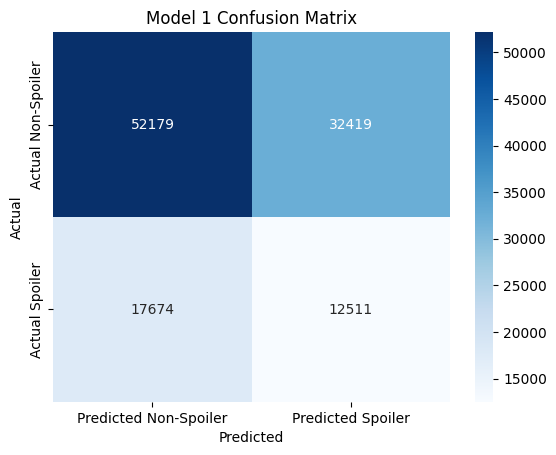

--- Overall Model Performance ---
Overall Accuracy: 56.36%

--- 'Spoiler' Class Performance ---
Precision (Spoiler): 0.2785
Recall (Spoiler):    0.4145
F1-Score (Spoiler):  0.3331

--- Confusion Matrix Breakdown ---
True Negatives (Non-Spoiler): 52179
False Positives (Non-Spoiler): 32419
False Negatives (Spoiler):    17674
True Positives (Spoiler):     12511


In [35]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# --- Create y_train and y_test labels ---
# These are the target variables (the actual 'is_spoiler' labels) 
# from your original train/test split.

y_train = train_df['is_spoiler']
y_test = test_df['is_spoiler']

print(f"y_train (labels) created with {len(y_train)} samples.")
print(f"y_test (labels) created with {len(y_test)} samples.")

# 'y_train' is the Series of labels you created during the initial train-test split
# 'X_train_cos_sim_features' is your DataFrame with 'review_length' and 'summary_similarity'

print(f"Original training set shape: {X_train_cos_sim_features.shape}")
print(f"Original spoiler count: {sum(y_train == True)}")

# Initialize SMOTE
# Note: Ensure X_train_cos_sim_features has no NaNs, as SMOTE requires clean data.
# Your fillna(0.0) from the previous step should handle this.
smote = SMOTE(random_state=42)

# Resample your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cos_sim_features, y_train)

print(f"\nResampled training set shape: {X_train_resampled.shape}")
print(f"Resampled spoiler count: {sum(y_train_resampled == True)}")

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
# n_jobs=-1 uses all available CPU cores to speed up training
model_cos_sim = RandomForestClassifier(random_state=42, n_jobs=-1)

print("Training Model 1 (Cosine Similarity Feature)...")
model_cos_sim.fit(X_train_resampled, y_train_resampled)

print("Model 1 trained successfully.")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the *original* test set
y_pred_cos_sim = model_cos_sim.predict(X_test_cos_sim_features)

print("\n--- Model 1 (Cosine Similarity) Results ---")

# Print the classification report
# This is the key output for evaluation
print(classification_report(y_test, y_pred_cos_sim, target_names=['Non-Spoiler', 'Spoiler']))

# --- Optional: Visualize the Confusion Matrix ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_cos_sim)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-Spoiler', 'Predicted Spoiler'],
            yticklabels=['Actual Non-Spoiler', 'Actual Spoiler'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Model 1 Confusion Matrix')
plt.show()

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)
import numpy as np

# --- Calculate Individual Scores ---

# Overall Accuracy
# (What percentage of all predictions were correct?)
acc = accuracy_score(y_test, y_pred_cos_sim)

# --- Metrics for the "Spoiler" (Positive) Class ---
# We set pos_label=True to get the scores for the 'Spoiler' class

# Precision (Spoiler)
# (Of all reviews we *predicted* as spoilers, how many were *actual* spoilers?)
precision = precision_score(y_test, y_pred_cos_sim, pos_label=True)

# Recall (Spoiler)
# (Of all *actual* spoilers, how many did we *find*?)
recall = recall_score(y_test, y_pred_cos_sim, pos_label=True)

# F1-Score (Spoiler)
# (The balanced average of Precision and Recall for the spoiler class)
f1 = f1_score(y_test, y_pred_cos_sim, pos_label=True)

# --- Confusion Matrix Breakdown ---
cm = confusion_matrix(y_test, y_pred_cos_sim)

# Unpack the confusion matrix
# Note: Assumes labels are [False, True] -> [0, 1]
# TN = True Negative (Correctly ID'd Non-Spoiler)
# FP = False Positive (Incorrectly ID'd Spoiler)
# FN = False Negative (We MISSED this Spoiler)
# TP = True Positive (Correctly ID'd Spoiler)

tn, fp, fn, tp = cm.ravel()

# --- Print Individual Scores ---

print("--- Overall Model Performance ---")
print(f"Overall Accuracy: {acc * 100:.2f}%")
print("\n--- 'Spoiler' Class Performance ---")
print(f"Precision (Spoiler): {precision:.4f}")
print(f"Recall (Spoiler):    {recall:.4f}")
print(f"F1-Score (Spoiler):  {f1:.4f}")
print("\n--- Confusion Matrix Breakdown ---")
print(f"True Negatives (Non-Spoiler): {tn}")
print(f"False Positives (Non-Spoiler): {fp}")
print(f"False Negatives (Spoiler):    {fn}")
print(f"True Positives (Spoiler):     {tp}")

Fitting PCA for 384 components to find the elbow...
PCA fitting complete. Plotting cumulative variance...


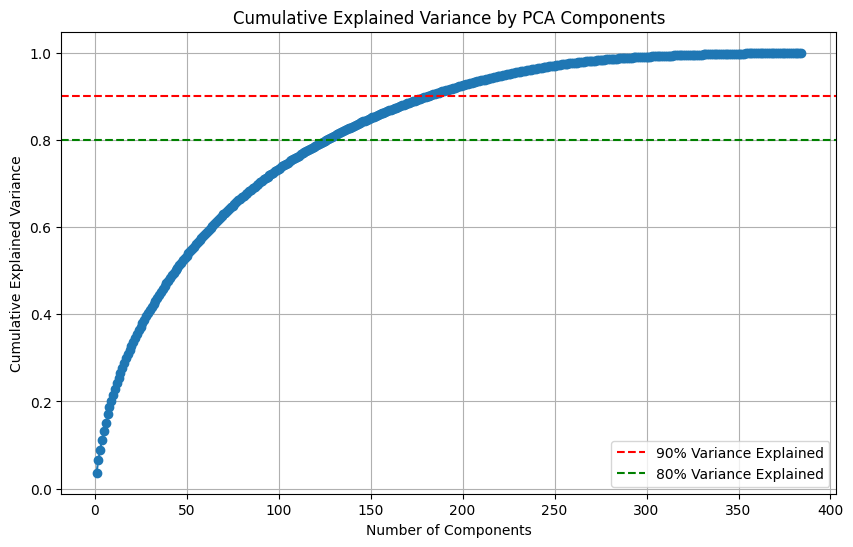

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Step 1: Fit a PCA model with a larger number of components ---
# We fit on the training embeddings (X_train_embeddings_np)
# Let's test up to 50 components to find the "elbow"
N_COMPONENTS_TO_TEST = 384

pca_analysis = PCA(n_components=N_COMPONENTS_TO_TEST)

print(f"Fitting PCA for {N_COMPONENTS_TO_TEST} components to find the elbow...")
pca_analysis.fit(X_train_embeddings_np)

# --- Step 2: Calculate the Cumulative Explained Variance ---
# explained_variance_ratio_ tells you the % of variance captured by each component
# We use cumsum() to see how much variance is captured as we add components
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)

print("PCA fitting complete. Plotting cumulative variance...")

# --- Step 3: Plot the Elbow Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_COMPONENTS_TO_TEST + 1), cumulative_variance, marker='o', linestyle='--')

# Add annotations
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% Variance Explained')
plt.legend(loc='lower right')
plt.show()

In [36]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# --- Step 1: Convert Embeddings to NumPy for scikit-learn ---
# We use the CPU tensors you created in your setup cell.
X_train_embeddings_np_pca = train_review_cpu.numpy()
X_test_embeddings_np_pca = test_review_cpu.numpy()

# --- Step 2: Set N_COMPONENTS based on your elbow plot analysis ---
# 125 components capture 80% of the variance.
N_COMPONENTS = 125

# --- Step 3: Fit PCA on Training Data ONLY ---
pca = PCA(n_components=N_COMPONENTS)
print(f"Fitting PCA for {N_COMPONENTS} components on training data...")
pca.fit(X_train_embeddings_np_pca)

# --- Step 4: Transform Both Sets ---
print("Transforming train and test embeddings...")
X_train_pca = pca.transform(X_train_embeddings_np_pca)
X_test_pca = pca.transform(X_test_embeddings_np_pca)

# --- Step 5: Create Final DataFrames for this Feature Set ---
# Create new column names for the PCA features
pca_cols = [f'pca_feature_{i+1}' for i in range(N_COMPONENTS)]

# Create new DataFrames from the PCA results, using the original index
# These DataFrames will contain ONLY the PCA features.
X_train_pca_features = pd.DataFrame(X_train_pca, columns=pca_cols, index=train_df.index)
X_test_pca_features = pd.DataFrame(X_test_pca, columns=pca_cols, index=test_df.index)

# 'y_train' and 'y_test' (your spoiler labels) are already created from your setup cell.

print(f"PCA feature set (n={N_COMPONENTS}) created successfully.")
print("\n--- Head of X_train_pca_features (Ready for Model 2) ---")
X_train_pca_features.head()

Fitting PCA for 125 components on training data...
Transforming train and test embeddings...
PCA feature set (n=125) created successfully.

--- Head of X_train_pca_features (Ready for Model 2) ---


,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4,pca_feature_5,pca_feature_6,pca_feature_7,pca_feature_8,pca_feature_9,pca_feature_10,...,pca_feature_116,pca_feature_117,pca_feature_118,pca_feature_119,pca_feature_120,pca_feature_121,pca_feature_122,pca_feature_123,pca_feature_124,pca_feature_125
94625,-0.354457,0.136884,-0.084431,0.011089,-0.142772,0.158541,-0.038906,0.063892,0.029004,0.007315,...,0.040736,0.017538,0.013397,-0.025141,0.038852,0.009837,0.052741,-0.007975,0.044943,-0.021196
89585,-0.209907,0.045797,0.201696,-0.172991,0.003071,-0.130432,0.060246,0.123954,-0.026533,0.014859,...,-0.017955,-0.049147,0.048021,-0.009040,0.061874,-0.084013,-0.128106,-0.025892,0.020572,-0.110485
187840,-0.046506,0.052240,-0.304204,-0.031475,0.065312,0.045258,0.079636,0.003284,0.071952,0.034714,...,0.018401,0.034774,-0.035886,0.004923,0.008456,0.000521,-0.064457,-0.015215,0.001472,0.023068
265694,0.245578,-0.038215,0.067622,-0.139756,0.108436,0.060521,0.107643,-0.104988,0.042125,0.053929,...,0.033089,-0.059447,-0.032021,0.000768,-0.032653,0.010163,-0.007167,0.036773,-0.060749,0.054320
125407,0.150508,-0.009703,-0.088379,-0.040481,0.006528,0.026780,0.023577,-0.096990,-0.040721,0.099028,...,0.017378,0.002436,0.075987,-0.040166,0.029313,-0.099549,-0.021421,0.085169,0.009752,0.023213


y_train (labels) created with 459130 samples.
y_test (labels) created with 114783 samples.
Original training set shape: (459130, 125)
Original spoiler count: 120739

Resampled training set shape: (241478, 125)
Resampled spoiler count: 120739
Training Model 2 (PCA Features)...

--- Model 2 (PCA Features) Full Report ---
              precision    recall  f1-score   support

 Non-Spoiler       0.83      0.63      0.72     84598
     Spoiler       0.38      0.63      0.47     30185

    accuracy                           0.63    114783
   macro avg       0.60      0.63      0.60    114783
weighted avg       0.71      0.63      0.65    114783


--- Overall Model Performance ---
Overall Accuracy: 63.12%

--- 'Spoiler' Class Performance ---
Precision (Spoiler): 0.3796
Recall (Spoiler):    0.6342
F1-Score (Spoiler):  0.4749

--- Confusion Matrix Breakdown ---
True Negatives (Non-Spoiler): 53306
False Positives (Non-Spoiler): 31292
False Negatives (Spoiler):    11042
True Positives (Spoiler): 

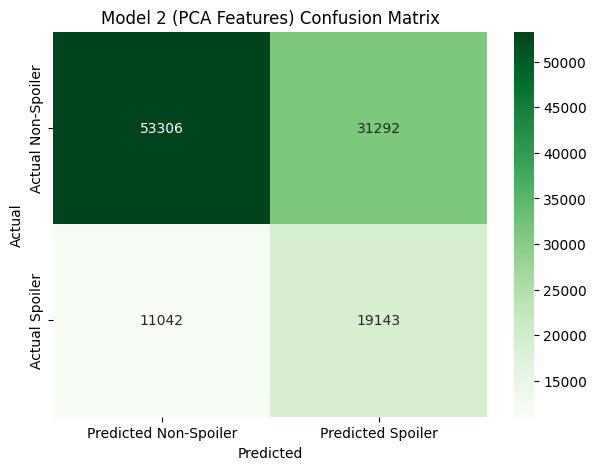

In [41]:
# Create the y_train and y_test labels (the 'is_spoiler' column)
# from your main train_df and test_df
y_train = train_df['is_spoiler']
y_test = test_df['is_spoiler']

print(f"y_train (labels) created with {len(y_train)} samples.")
print(f"y_test (labels) created with {len(y_test)} samples.")



# from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# X_train_pca_features (125 features) and y_train (labels) are in memory

print(f"Original training set shape: {X_train_pca_features.shape}")
print(f"Original spoiler count: {sum(y_train == True)}")

# # Initialize SMOTE
# smote_pca = SMOTE(random_state=42)

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample your training data
X_train_pca_resampled, y_train_pca_resampled = rus.fit_resample(X_train_pca_features, y_train)

print(f"\nResampled training set shape: {X_train_pca_resampled.shape}")
print(f"Resampled spoiler count: {sum(y_train_pca_resampled == True)}")


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Train the model
print("Training Model 2 (PCA Features)...")
model_pca = RandomForestClassifier(random_state=42, n_jobs=-1)
model_pca.fit(X_train_pca_resampled, y_train_pca_resampled)

# 2. Evaluate on the (un-resampled) test set
y_pred_pca = model_pca.predict(X_test_pca_features)

print("\n--- Model 2 (PCA Features) Full Report ---")
# Print the full classification report
print(classification_report(y_test, y_pred_pca, target_names=['Non-Spoiler', 'Spoiler']))

# --- Calculate Individual Scores ---
acc_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca, pos_label=True)
recall_pca = recall_score(y_test, y_pred_pca, pos_label=True)
f1_pca = f1_score(y_test, y_pred_pca, pos_label=True)
cm_pca = confusion_matrix(y_test, y_pred_pca)
tn_pca, fp_pca, fn_pca, tp_pca = cm_pca.ravel()

# --- Print Individual Scores ---
print("\n--- Overall Model Performance ---")
print(f"Overall Accuracy: {acc_pca * 100:.2f}%")
print("\n--- 'Spoiler' Class Performance ---")
print(f"Precision (Spoiler): {precision_pca:.4f}")
print(f"Recall (Spoiler):    {recall_pca:.4f}")
print(f"F1-Score (Spoiler):  {f1_pca:.4f}")
print("\n--- Confusion Matrix Breakdown ---")
print(f"True Negatives (Non-Spoiler): {tn_pca}")
print(f"False Positives (Non-Spoiler): {fp_pca}")
print(f"False Negatives (Spoiler):    {fn_pca}")
print(f"True Positives (Spoiler):     {tp_pca}")

# --- Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix Visual ---")
plt.figure(figsize=(7, 5))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted Non-Spoiler', 'Predicted Spoiler'],
            yticklabels=['Actual Non-Spoiler', 'Actual Spoiler'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Model 2 (PCA Features) Confusion Matrix')
plt.show()



In [38]:
import torch
import pandas as pd
import numpy as np

# (We assume X_train_embeddings_tensor, X_test_embeddings_tensor, y_train,
#  train_df, and test_df are in memory from previous steps)

# --- Step 1: Convert Embeddings to Tensors ---
# We use the CPU tensors you created and move them to the active device ('mps' or 'cpu')
X_train_embeddings_tensor = torch.tensor(train_review_cpu.numpy(), device=device)
X_test_embeddings_tensor = torch.tensor(test_review_cpu.numpy(), device=device)
y_train_series = train_df['is_spoiler']

# --- Step 2: Create Boolean Mask from y_train ---
# This helps us select the spoiler vs. non-spoiler embeddings
y_train_bool = y_train_series.astype(bool).values

# --- Step 3: Calculate Prototypes (from Training Data ONLY) ---
print("Calculating prototypes from training data...")

# Calculate the average vector for all spoiler reviews
spoiler_prototype = torch.mean(X_train_embeddings_tensor[y_train_bool], dim=0, keepdim=True)

# Calculate the average vector for all non-spoiler reviews
non_spoiler_prototype = torch.mean(X_train_embeddings_tensor[~y_train_bool], dim=0, keepdim=True)

print("Prototypes calculated.")

# --- Step 4: Calculate Similarities for all reviews ---
print("Calculating similarity to prototypes for train and test sets...")

# Calculate similarities for the training set
sim_to_spoiler_train = util.pairwise_cos_sim(X_train_embeddings_tensor, spoiler_prototype)
sim_to_non_spoiler_train = util.pairwise_cos_sim(X_train_embeddings_tensor, non_spoiler_prototype)

# Calculate similarities for the test set (using the *same* prototypes)
sim_to_spoiler_test = util.pairwise_cos_sim(X_test_embeddings_tensor, spoiler_prototype)
sim_to_non_spoiler_test = util.pairwise_cos_sim(X_test_embeddings_tensor, non_spoiler_prototype)

# --- Step 5: Create Final DataFrames for this Feature Set ---
# Create the independent feature sets
X_train_prototype_features = pd.DataFrame({
    'sim_to_spoiler': sim_to_spoiler_train.cpu().flatten(),
    'sim_to_non_spoiler': sim_to_non_spoiler_train.cpu().flatten()
}, index=train_df.index)

X_test_prototype_features = pd.DataFrame({
    'sim_to_spoiler': sim_to_spoiler_test.cpu().flatten(),
    'sim_to_non_spoiler': sim_to_non_spoiler_test.cpu().flatten()
}, index=test_df.index)

# 'y_train' and 'y_test' are already created from your setup cell.

print("Prototype similarity features added successfully.")
print("\n--- Head of X_train_prototype_features (Ready for Model 3) ---")
X_train_prototype_features.head()

Calculating prototypes from training data...
Prototypes calculated.
Calculating similarity to prototypes for train and test sets...
Prototype similarity features added successfully.

--- Head of X_train_prototype_features (Ready for Model 3) ---


,sim_to_spoiler,sim_to_non_spoiler
94625,0.316288,0.289253
89585,0.317258,0.288944
187840,0.701135,0.697427
265694,0.706337,0.714787
125407,0.623856,0.636005


--- Average Similarity to Prototypes (Grouped by Actual Label) ---
            sim_to_spoiler  sim_to_non_spoiler
is_spoiler                                    
False               0.5700              0.5759
True                0.5529              0.5471

--- Visualizing Feature Effectiveness ---


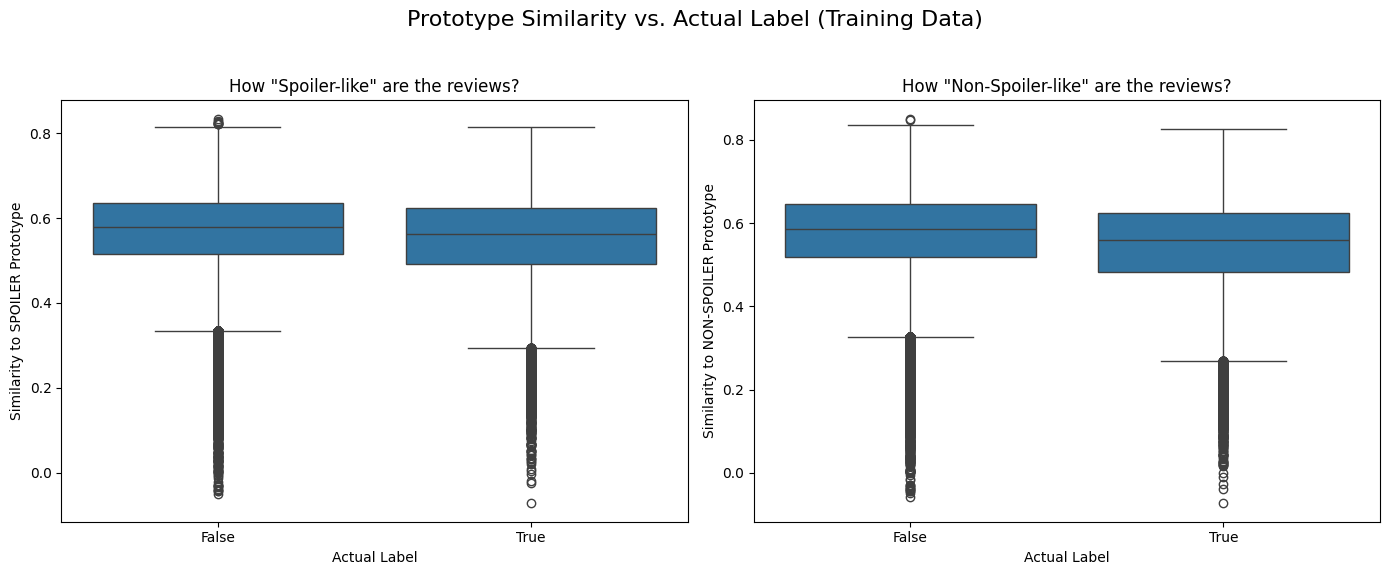

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Combine features and labels for analysis ---
# FIX: Join with y_train_series (which is train_df['is_spoiler']), not 'y_train'
analysis_df_proto = X_train_prototype_features.join(y_train_series) 

# --- Step 2: Calculate the mean scores for each class ---
print("--- Average Similarity to Prototypes (Grouped by Actual Label) ---")
avg_sim_df = analysis_df_proto.groupby('is_spoiler')[['sim_to_spoiler', 'sim_to_non_spoiler']].mean()
print(avg_sim_df.round(4))

# --- Step 3: Visualize the distributions with boxplots ---
print("\n--- Visualizing Feature Effectiveness ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Similarity to SPOILER Prototype
sns.boxplot(ax=axes[0], x='is_spoiler', y='sim_to_spoiler', data=analysis_df_proto)
axes[0].set_title('How "Spoiler-like" are the reviews?')
axes[0].set_xlabel('Actual Label')
axes[0].set_ylabel('Similarity to SPOILER Prototype')

# Plot 2: Similarity to NON-SPOILER Prototype
sns.boxplot(ax=axes[1], x='is_spoiler', y='sim_to_non_spoiler', data=analysis_df_proto)
axes[1].set_title('How "Non-Spoiler-like" are the reviews?')
axes[1].set_xlabel('Actual Label')
axes[1].set_ylabel('Similarity to NON-SPOILER Prototype')

plt.suptitle('Prototype Similarity vs. Actual Label (Training Data)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()